## Combine Kw-based models with LM-based models.
What happens? Can it improve further?

In [26]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.preprocessing import normalize

In [27]:
def zero_one_normalize(X):
    return (X - np.min(X)) / (np.max(X) - np.min(X))


def trunc(values, decs=2):
    return np.trunc(values * 10**decs) / (10**decs)

In [46]:
base_model = "msmarco-MiniLM-L6-cos-v5"
LM_model = "SUM_docs_sum_wiki_sum"

LM_knowledges = pickle.load(open(f"../data/{base_model}_knowledge_gains.pkl", "rb"))[LM_model]
LM_vector = np.array([LM_knowledges[u]["final_sim"] for u in user_ids])

# KW_knowledges = {l.split()[0]: float(l.strip().split()[-1]) for l in open("../calculated gain.csv").readlines()[1:]}
# KW_vector = np.array([KW_knowledges[u] for u in user_ids])

KW_knowledges = pickle.load(open("../data/Arthur_KW_Knowledges.pkl", "rb"))["3"]
KW_vector = np.array([KW_knowledges[u]["final_sim"] for u in user_ids])

actual_learning = {k: LM_knowledges[k]["ALG"] for k in LM_knowledges}
learning_vector = np.array([actual_learning[u] for u in user_ids])


user_ids = list(LM_knowledges.keys())

In [47]:
best_alpha = 0.0
best_corr = 0.0

df_list = []


for alpha in trunc(np.arange(0, 1.01, 0.01)):
    beta = 1 - alpha
    final_score = alpha * LM_vector + beta * KW_vector
    corr, p_val = pearsonr(final_score, learning_vector)
    corr_vs_LM, p_LM = pearsonr(final_score, LM_vector)
    corr_vs_KW, p_KW = pearsonr(final_score, KW_vector)

    df_list.append(
        {
            "alpha": alpha,
            "pearson": corr,
            "pearson_p": p_val,
            "avg_learning": np.mean(learning_vector),
            "avg_KW_estimation": np.mean(KW_vector),
            "avg_LM_estimation": np.mean(LM_vector),
            "avg_comb_estimation": np.mean(final_score),
            "p_vs_LM": p_LM,
            "p_vs_KW": p_KW,
        }
    )
    if corr > best_corr:
        best_p_val = p_val
        best_corr = corr
        best_alpha = alpha
    # print(f"{alpha:.2f} - {corr:.4f} ({p_val})")
print(f"Best alpha: {best_alpha:.2f} with pearson correlation of {best_corr:.5f}")
df = pd.DataFrame(df_list)

Best alpha: 0.30 with pearson correlation of 0.31135


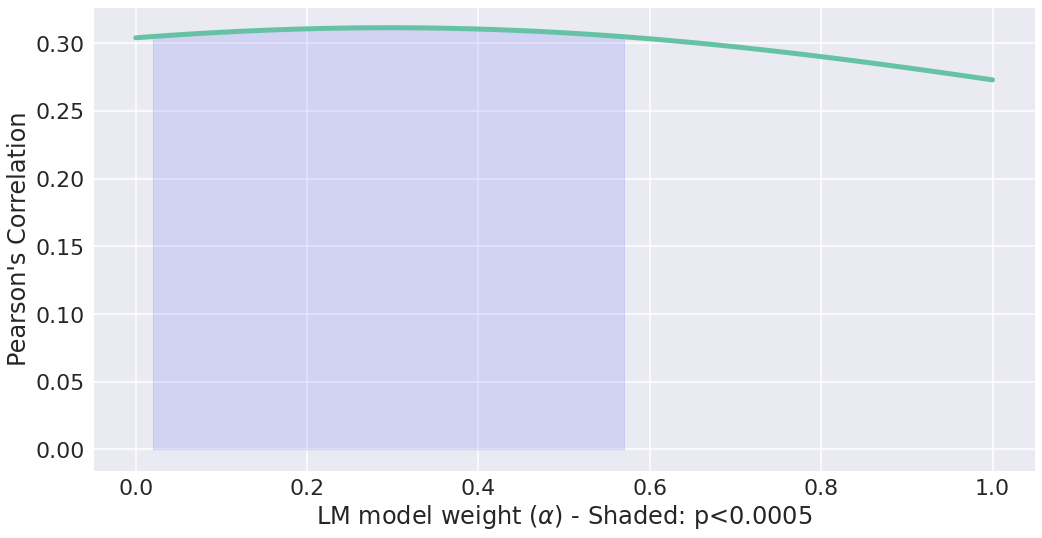

In [49]:
rel_level = 0.0005

plt.figure()
sns.set(rc={"figure.figsize": (15, 8), "figure.autolayout": True})
sns.set_style("darkgrid")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=2.5, rc={"grid.linewidth": 1.5, "lines.linewidth": 5.0})

graph = sns.lineplot(data=df, x="alpha", y="pearson")
graph.set_ylabel("Pearson's Correlation")
graph.set_xlabel(r"LM model weight ($\alpha$) " f"- Shaded: p<{rel_level}")

line = graph.axes.lines[0]
good_alphas = df[df.pearson_p < rel_level].alpha

x1 = good_alphas.values
y1 = df[df.alpha.isin(x1)].pearson
graph.fill_between(x1, y1, color="blue", alpha=0.1)

good_alphas_LM = df[df.p_vs_LM > rel_level].alpha
x1 = good_alphas_LM.values
y1 = df[df.alpha.isin(x1)].pearson
# graph.fill_between(x1, y1, color="red", alpha=0.1)


good_alphas_LM = df[df.p_vs_KW > rel_level].alpha
x1 = good_alphas_LM.values
y1 = df[df.alpha.isin(x1)].pearson
# graph.fill_between(x1, y1, color="orange", alpha=0.1)

## Other Analysis

In [72]:
# Win-Lose - What charactersitics sessions where KW is better than LM have?
# Build a dataset where each line is a user
dataset = json.load(open("../data/logs_with_position.json"))
stats = pd.read_csv("../data/CHIIR2021_data/consolidated.csv", index_col=0)

In [86]:
# for each user, get which model is better. Do joins afterwards for better understanding.
win_lose = []
for u, lm_e, kw_e in zip(user_ids, LM_vector, KW_vector):
    combi_score = (best_alpha * lm_e) + ((1 - alpha) * kw_e)
    win_lose.append({"user": u, "LM_estimate": lm_e, "KW_estimate": kw_e, "COMBI_estimate": combi_score})
df_2 = pd.DataFrame(win_lose).set_index("user")
stats = stats.join(df_2, on="user")

In [103]:
# Try by session length.
less_than_half = stats[stats.session_duration < stats.session_duration.median()]
more_than_half = stats[stats.session_duration > stats.session_duration.median()]

# For each, which model is a better estimator?
corr_LM = pearsonr(less_than_half.LM_estimate, less_than_half.absolute_learning_gain)[0]
corr_KW = pearsonr(less_than_half.KW_estimate, less_than_half.absolute_learning_gain)[0]
corr_COMBI = pearsonr(less_than_half.COMBI_estimate, less_than_half.absolute_learning_gain)[0]
print(corr_LM, corr_KW, corr_COMBI)

corr_LM = pearsonr(more_than_half.LM_estimate, more_than_half.absolute_learning_gain)[0]
corr_KW = pearsonr(more_than_half.KW_estimate, more_than_half.absolute_learning_gain)[0]
corr_COMBI = pearsonr(more_than_half.COMBI_estimate, more_than_half.absolute_learning_gain)[0]
print(corr_LM, corr_KW, corr_COMBI)

0.3189363498686631 0.3008027303916447 0.3189363498686632
0.1820804691753904 0.3134295023754293 0.18208046917539034


In [ ]:
#Try by session length.

less_than_half = stats[stats.session_duration<stats.session_duration.median()]
more_than_half = stats[stats.session_duration>stats.session_duration.median()]

# For each, which model is a better estimator?
corr_LM = pearsonr(less_than_half.LM_estimate, less_than_half.absolute_learning_gain)[0]
corr_KW = pearsonr(less_than_half.KW_estimate, less_than_half.absolute_learning_gain)[0]
corr_COMBI = pearsonr(less_than_half.COMBI_estimate, less_than_half.absolute_learning_gain)[0]
print(corr_LM, corr_KW, corr_COMBI)

corr_LM = pearsonr(more_than_half.LM_estimate, more_than_half.absolute_learning_gain)[0]
corr_KW = pearsonr(more_than_half.KW_estimate, more_than_half.absolute_learning_gain)[0]
corr_COMBI = pearsonr(more_than_half.COMBI_estimate, more_than_half.absolute_learning_gain)[0]
print(corr_LM, corr_KW, corr_COMBI)

In [105]:
stats.head()

,user,absolute_learning_gain,realized_learning_gain,type,average_query_len,number_of_queries,number_of_views,number_of_clicks,session_duration,one_two_to_four,...,valid_questions,topic,average_dwell_time,unique_docs,number_of_bookmars,education_level,search_time,LM_estimate,KW_estimate,COMBI_estimate
0,5ce456ea65535c0019185cd6,0.7,0.350000,control,5.500000,2,35,14,2407,3,...,4,Subprime mortgage crisis,22,12,9,Other,2086,0.906224,0.935750,0.271867
1,56e06fde907c12000ae3ab94,1.1,0.550000,visual,2.750000,4,45,8,3835,5,...,4,Radiocarbon dating considerations,180,6,1,Bachelor's degree(s),1994,0.540178,0.854674,0.162053
2,5d53ec22cb1bcf0015f59a65,1.0,0.526316,visual,1.833333,12,145,23,3399,4,...,4,Ethics,4,21,21,Bachelor's degree(s),2427,0.889278,0.980398,0.266783
3,5cdd2cd048d5f100155fabce,1.0,0.500000,control,4.000000,4,45,9,2358,5,...,4,Subprime mortgage crisis,202,7,2,Bachelor's degree(s),1784,0.919172,0.969106,0.275752
4,5d78fcd59066d90001a4977a,0.4,0.200000,visual,3.666667,9,95,15,2230,1,...,4,Radiocarbon dating considerations,91,15,7,Bachelor's degree(s),1773,0.728864,0.769146,0.218659


In [100]:
corr_LM, corr_KW, corr_COMBI

((0.1820804691753904, 0.1532203073040214),
 (0.3134295023754293, 0.012372837165776482),
 (0.18208046917539034, 0.1532203073040214))

In [74]:
stats[stats.user.isin(user_ids)]

(127, 21)

In [136]:
print(stats.columns)

Index(['user', 'absolute_learning_gain', 'realized_learning_gain', 'type',
       'average_query_len', 'number_of_queries', 'number_of_views',
       'number_of_clicks', 'session_duration', 'one_two_to_four',
       'one_two_to_three', 'three_to_four', 'one_two_no_change', 'other',
       'valid_questions', 'topic', 'average_dwell_time', 'unique_docs',
       'number_of_bookmars', 'education_level', 'search_time', 'LM_estimate',
       'KW_estimate', 'COMBI_estimate'],
      dtype='object')


In [77]:
stats.head()

,user,absolute_learning_gain,realized_learning_gain,type,average_query_len,number_of_queries,number_of_views,number_of_clicks,session_duration,one_two_to_four,...,three_to_four,one_two_no_change,other,valid_questions,topic,average_dwell_time,unique_docs,number_of_bookmars,education_level,search_time
0,5ce456ea65535c0019185cd6,0.7,0.350000,control,5.500000,2,35,14,2407,3,...,0,6,0,4,Subprime mortgage crisis,22,12,9,Other,2086
1,56e06fde907c12000ae3ab94,1.1,0.550000,visual,2.750000,4,45,8,3835,5,...,0,4,0,4,Radiocarbon dating considerations,180,6,1,Bachelor's degree(s),1994
2,5d53ec22cb1bcf0015f59a65,1.0,0.526316,visual,1.833333,12,145,23,3399,4,...,1,4,0,4,Ethics,4,21,21,Bachelor's degree(s),2427
3,5cdd2cd048d5f100155fabce,1.0,0.500000,control,4.000000,4,45,9,2358,5,...,0,5,0,4,Subprime mortgage crisis,202,7,2,Bachelor's degree(s),1784
4,5d78fcd59066d90001a4977a,0.4,0.200000,visual,3.666667,9,95,15,2230,1,...,0,7,0,4,Radiocarbon dating considerations,91,15,7,Bachelor's degree(s),1773


1095

In [151]:
col = "number_of_views"
print(f"{stats[col].sum()}")
print(f"{stats[col].mean():.2f} \\pm {stats[col].std():.2f}")
print(f"{stats[col].median()}")

15184
119.56 \pm 72.43
105.0


In [132]:
stats.groupby("topic").user.count().median()

19.0

In [143]:
aux_df = stats.number_of_clicks / stats.number_of_queries
print(f"{aux_df.mean():.2f} \\pm {aux_df.std():.2f}")
print(f"{aux_df.median():.2f}")

2.78 \pm 2.50
2.11
